In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.0 MB

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

Segmentation Models: using `tf.keras` framework.


In [4]:
from keras import backend as K
from keras.models import load_model

In [5]:
import gradio as gr

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [8]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [9]:
satellite_model = load_model('/content/drive/MyDrive/Capstone Project/Satelite_Segmentation-Resnet34.h5',
                         custom_objects=({
        'dice_loss_plus_1focal_loss': total_loss,
        'jaccard_coef': jaccard_coef,
        'dice_coef': dice_coef }))

In [10]:
satellite_model.get_config()

{'name': 'model_1',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'data'},
   'registered_name': None,
   'name': 'data',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'BatchNormalization',
   'config': {'name': 'bn_data',
    'trainable': True,
    'dtype': 'float32',
    'axis': [3],
    'momentum': 0.99,
    'epsilon': 2e-05,
    'center': True,
    'scale': False,
    'beta_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'gamma_initializer': {'module': 'keras.initializers',
     'class_name': 'Ones',
     'config': {},
     'registered_name': None},
    'moving_mean_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'moving_

In [27]:
image = Image.open('/content/drive/MyDrive/Capstone Project/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [28]:
prediction = satellite_model.predict(image)

1/1 [==============================] - 0s 349ms/step


In [29]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [30]:
type(predicted_image)

numpy.ndarray

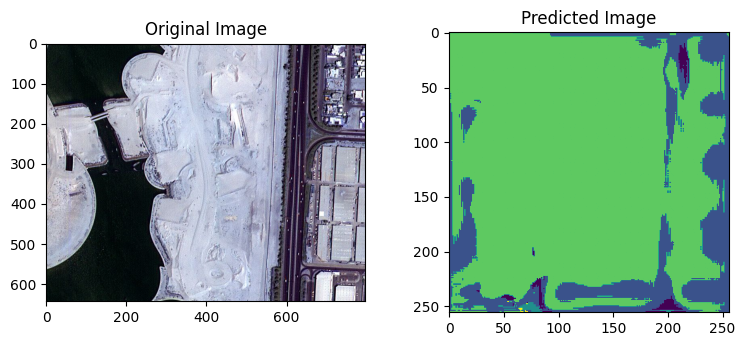

In [31]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/drive/MyDrive/Capstone Project/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
def process_input_image(image_source):
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)
  predicted_image = np.argmax(prediction, axis=3)

  predicted_image = predicted_image[0,:,:]
  predicted_image = predicted_image * 50
  return 'Predicted Masked Image', predicted_image

In [ ]:
my_app = gr.Blocks()

In [ ]:
with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image", shape=(256, 256))
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [ ]:
my_app.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c40d66e388177aced8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 534, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1554, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1192, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

1/1 [==============================] - 1s 671ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c40d66e388177aced8.gradio.live


In [ ]:
my_app.close()

Closing server running on port: 7860
